# Analysis of disk IO operations of storage engines

## Functions for analyzing profiling

In [10]:
import numpy as np 
import matplotlib.pyplot as plt
import re

log_line_pattern = r'^\s*\d\s+\d+\s+(W|R)\s+\d+.+$'

def analyze_disk_io_logs_for_workload(disk_io_log_file_path):
    log_file = open(disk_io_log_file_path, 'r')

    line_count = 0

    io = { 'R': 0, 'W': 0 }

    for log_line in log_file:
        line_count += 1

        # Skipping the first line and empty lines
        if line_count == 1 or len(log_line.strip()) == 0:
            continue

        match = re.match(log_line_pattern, log_line)

        if match is None:
            continue

        operation_type = match.group(1)

        io[operation_type] += 1

    reads = io['R']
    writes = io['W']

    log_file.close()

    return writes, reads, reads + writes

def analyze_disk_io_logs_for_storage_engine(disk_io_log_files_directory_path, workload_sizes):
    disk_io_profile = { 'writes': {}, 'reads': {}, 'total': {} }

    for workload_size in workload_sizes:
        disk_io_log_file_path = os.path.join(disk_io_log_files_directory_path, str(workload_size))

        workload_disk_io_profile = analyze_disk_io_logs_for_workload(disk_io_log_file_path)

        disk_io_profile['writes'][workload_size] = workload_disk_io_profile[0]
        disk_io_profile['reads'][workload_size] = workload_disk_io_profile[1]
        disk_io_profile['total'][workload_size] = workload_disk_io_profile[2]

    return disk_io_profile

def analyze_disk_io_logs(profile_files_directory_path, storage_engine_types, workload_sizes):
    storage_engine_disk_io_profiles = {}

    for storage_engine_type in storage_engine_types:
        storage_engine_disk_io_logs_file_path = os.path.join(profile_files_directory_path, storage_engine_type)

        storage_engine_disk_io_profiles[storage_engine_type] = analyze_disk_io_logs_for_storage_engine(storage_engine_disk_io_logs_file_path, workload_sizes)

    return storage_engine_disk_io_profiles

## Functions for drawing disk IO operations charts

In [11]:
def disk_io_profile_chart_for(profiles, storage_engine_types, storage_engine_names, workload_type, workload_sizes):
    count = 0

    plt.figure(figsize = (20, 10))

    for storage_engine_type in storage_engine_types:
        throughputs = [profiles[storage_engine_type][workload_type][workload_size] for workload_size in workload_sizes]

        plt.plot(workload_sizes, throughputs, label = storage_engine_names[count])

        count += 1

    plt.title('Disk IO ' + workload_type + ' comparison')
    plt.xlabel('Number of documents written')
    plt.ylabel('Number of operations')
    plt.legend()

    plt.show()

## Disk IO operations profiling comparison charts

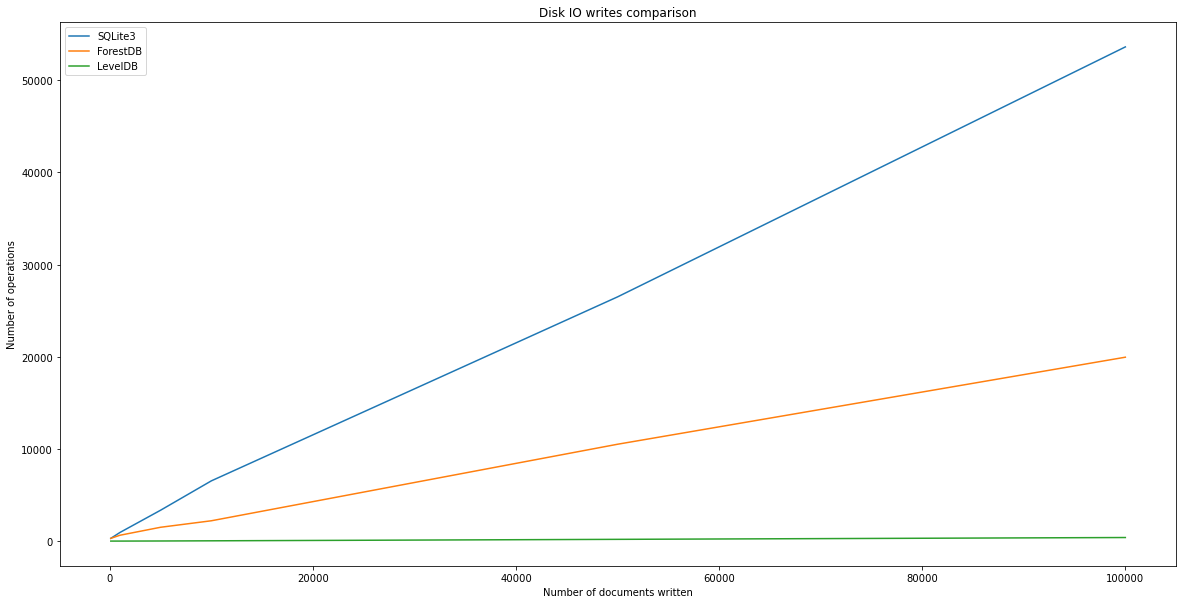

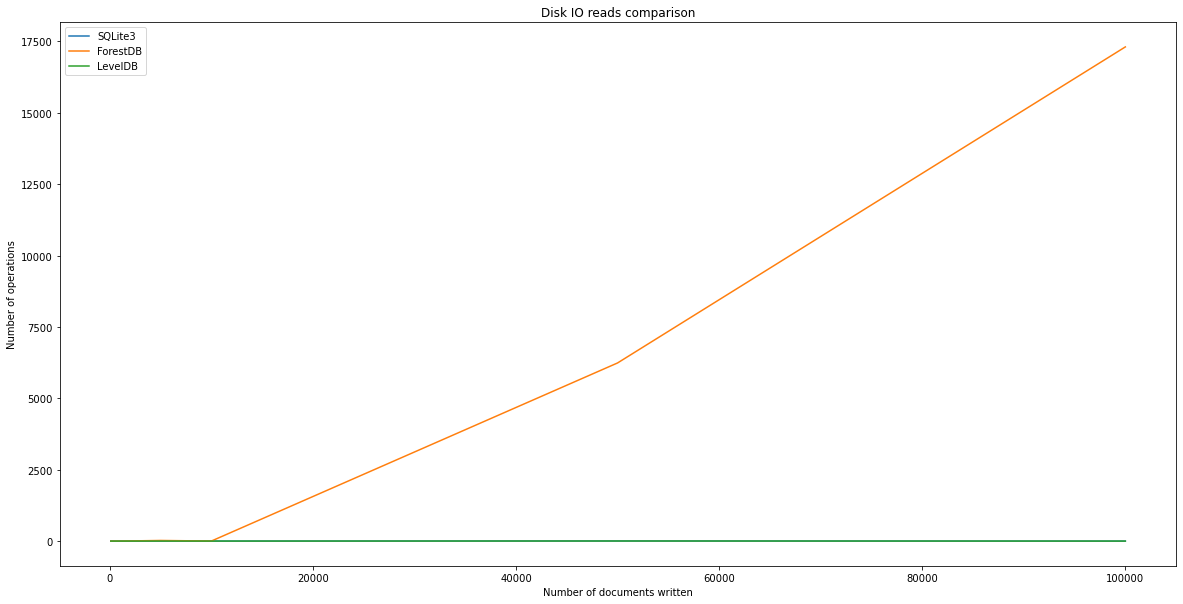

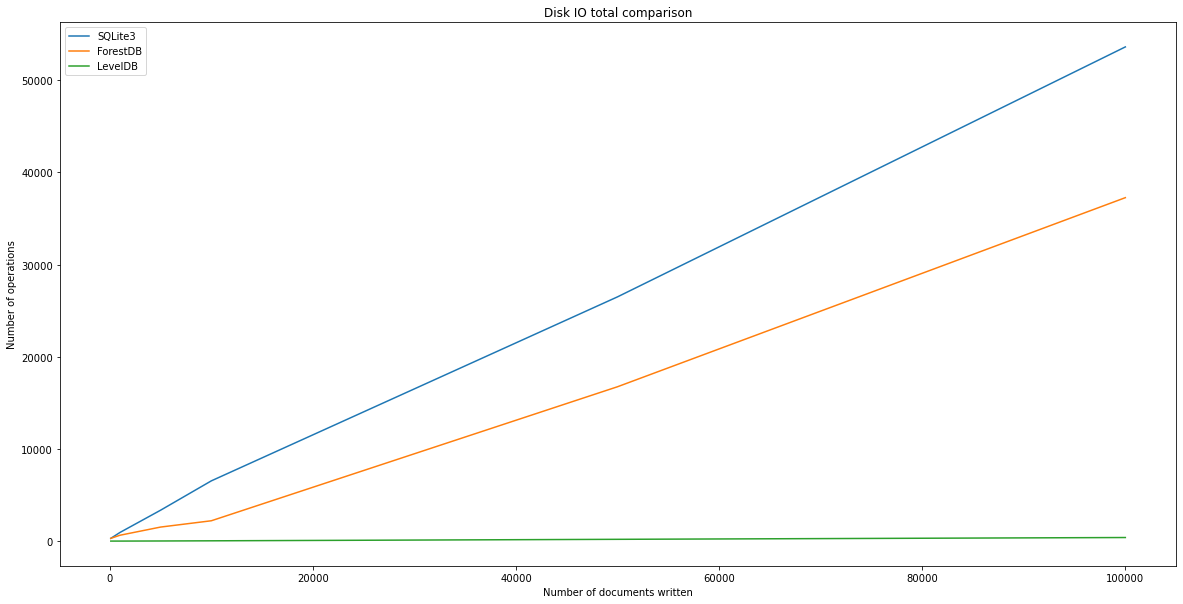

In [12]:
# Storage engines and workload sizes to analyze
# -----------------------------------------------------------------
# Types and names of storage engines
STORAGE_ENGINE_TYPES = ['sqlite3', 'forestdb', 'leveldb']
STORAGE_ENGINE_NAMES = ['SQLite3', 'ForestDB', 'LevelDB']

# Workload settings
WORKLOAD_TYPES= ['writes', 'reads', 'total']  # Types of workloads to analyze and visualize
WORKLOAD_SIZES = [100, 1000, 5000, 10000, 50000, 100000]  # Sizes of workloads to analyze and visualize

# Analyzing the logs / building profiles
# -----------------------------------------------------------------

profiles = analyze_disk_io_logs('../metrics/profiling', STORAGE_ENGINE_TYPES, WORKLOAD_SIZES)

# Drawing charts for comparison
# -----------------------------------------------------------------

for workload_type in WORKLOAD_TYPES:
    disk_io_profile_chart_for(profiles, STORAGE_ENGINE_TYPES, STORAGE_ENGINE_NAMES, workload_type, WORKLOAD_SIZES)